In [1]:
def is_start_of_daily_block(date_series):
    """
    Returns a boolean Series indicating if each date in the input Series is the 
    start of a new sequence of consecutive dates.

    :param date_series: Pandas Series with datetime objects.
    :return: Pandas Series of boolean values.
    """
    # Ensure the Series is sorted
    sorted_series = date_series.sort_values()

    # Calculate the difference in days between each date and the previous date
    day_diff = sorted_series.diff().dt.days

    # Mark True where the difference is greater than 1 day, indicating a new sequence
    is_start = day_diff > 1

    # Handle the first element
    if not is_start.empty:
        is_start.iloc[0] = True

    return is_start

In [2]:
import utils

In [3]:
import pickle

In [33]:
import pandas as pd
import re

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

extruder = 'EX2'

ex_data = pd.read_csv(f"data/{extruder}_processed.csv")
ex_data['Unnamed: 0'] = pd.to_datetime(ex_data['Unnamed: 0'])
ex_data = ex_data.set_index('Unnamed: 0').rename_axis('Date and Time')
#ex_data.index = pd.to_datetime(ex_data.index)
ex_data.dropna(inplace=True)

In [5]:
type(ex_data.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [6]:
min_time = ex_data.index.min()
well_sampled_cutoff = min_time + pd.Timedelta(hours=48)
min_time, well_sampled_cutoff

ex_data.loc[ex_data.index < well_sampled_cutoff,'well_sampled'] = False

In [7]:
len(ex_data)

442690

In [8]:
#ex_data['Date and Time'] = ex_data.index

In [9]:
for time_window in ['5T', '15T', '30T', '1H', '3H', '6H', '12H', '24H', '48H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')

    col_label = 'pressure-' + label_append + '_avg'
    ex_data[col_label] = ex_data['Extruder Pressure'].rolling(time_window).mean()

    col_label = 'pressure-' + label_append + '_var'
    ex_data[col_label] = ex_data['Extruder Pressure'].rolling(time_window).var()

In [10]:
ex_data.columns

Index(['Extruder Pressure', 'Screw Speed Output', 'Screw Speed',
       'Extruder Die Temp', 'Extruder Thrust ', 'Feed Screw Current (Amps)',
       'Discharge Conveyor Current (Amps)', 'Discharge Conveyor Speed (%)',
       'sample_gap_minutes', '48H_max_gap_backward', '1H_max_gap_forward',
       'well_sampled', 'HAZARD_CONDITION', 'hours_to_hazard',
       'hazard_within_24h', 'pressure-5min_avg', 'pressure-5min_var',
       'pressure-15min_avg', 'pressure-15min_var', 'pressure-30min_avg',
       'pressure-30min_var', 'pressure-1hour_avg', 'pressure-1hour_var',
       'pressure-3hour_avg', 'pressure-3hour_var', 'pressure-6hour_avg',
       'pressure-6hour_var', 'pressure-12hour_avg', 'pressure-12hour_var',
       'pressure-24hour_avg', 'pressure-24hour_var', 'pressure-48hour_avg',
       'pressure-48hour_var'],
      dtype='object')

In [11]:
variables_to_lag = ['Extruder Die Temp', 'Extruder Thrust ',
                    'Screw Speed Output']

colname_map = {
    'Extruder Die Temp' : 'die_temp-',
    'Extruder Thrust ' : 'thrust-',
    'Screw Speed Output' : 'screw_speed_output-',
}

for time_window in ['15T', '1H', '3H', '6H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')
    for lagvar in variables_to_lag:
        col_label = colname_map[lagvar] + label_append + '_avg'
        ex_data[col_label] = \
            ex_data[lagvar].rolling(time_window).mean()

In [12]:
#min_datetime = pauses.min() - pd.Timedelta(days=7)
#max_datetime = pauses.max()#

#time_mask = (ex_data.index >= min_datetime) \
#            & (ex_data.index <= max_datetime)
#ex_data = ex_data[time_mask]#
#
#ex_data = ex_data[redundancy_mask]

In [13]:
#with open(f'models/regression_models_no_screw_speed_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
#    pickle.dump((output_models, results), f)

In [14]:
with open('models/regression_models_no_screw_speed_with_normalization_EX2_30H.pkl', 'rb') as f:
    output_models, results, input_features, target_features = pickle.load(f)

In [15]:
output_models.keys()

dict_keys(['hours_to_hazard', '_scaling'])

In [16]:
scaler = output_models['_scaling']
model = output_models['hours_to_hazard']['Random Forest Regressor']

In [17]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-1hour_avg',
    'pressure-12hour_avg',
    'pressure-5min_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
#model_input = well_sampled_data[input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_features]
#model_output = well_sampled_data[target_features]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]
#model_input_test = model_input

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]
#model_output_test = model_output

In [46]:
test = well_sampled_data[well_sampled_data.index >= train_split_cutoff]
test[test['hours_to_hazard'] < 10].iloc[1150:1200]

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),sample_gap_minutes,48H_max_gap_backward,1H_max_gap_forward,well_sampled,HAZARD_CONDITION,hours_to_hazard,hazard_within_24h,pressure-5min_avg,pressure-5min_var,pressure-15min_avg,pressure-15min_var,pressure-30min_avg,pressure-30min_var,pressure-1hour_avg,pressure-1hour_var,pressure-3hour_avg,pressure-3hour_var,pressure-6hour_avg,pressure-6hour_var,pressure-12hour_avg,pressure-12hour_var,pressure-24hour_avg,pressure-24hour_var,pressure-48hour_avg,pressure-48hour_var,die_temp-15min_avg,thrust-15min_avg,screw_speed_output-15min_avg,die_temp-1hour_avg,thrust-1hour_avg,screw_speed_output-1hour_avg,die_temp-3hour_avg,thrust-3hour_avg,screw_speed_output-3hour_avg,die_temp-6hour_avg,thrust-6hour_avg,screw_speed_output-6hour_avg
Date and Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-18 02:39:30,3949.324219,25.0,27.762321,259.968750,68.859680,5.68,0.88,80.0,0.033333,5.933333,5.883333,True,False,0.408333,True,3994.011328,1.373636e+03,3983.679492,1247.034376,3976.228060,1199.006195,3930.214176,3625.008040,3840.778879,7217.186214,3797.294911,6698.601495,3829.328257,18480.955658,3961.461895,28094.084792,4025.491182,19732.044150,259.968750,68.676594,25.0,260.457520,67.328227,25.0,259.032340,66.300543,25.0,259.991149,66.130434,25.0
2023-12-18 02:40:00,3997.642578,25.0,27.762321,260.630859,68.812180,5.68,0.88,80.0,0.050000,5.933333,5.883333,True,False,0.400000,True,3992.975781,1.352174e+03,3985.044596,1226.710248,3976.666471,1206.177984,3931.928467,3499.552530,3841.672179,7209.344672,3797.716946,6739.345666,3829.321045,18478.451330,3961.434520,28089.943480,4025.466948,19730.010202,259.990820,68.696774,25.0,260.456771,67.353611,25.0,259.041895,66.309682,25.0,259.989988,66.134617,25.0
2023-12-18 02:40:30,4042.675781,25.0,27.762321,260.630859,68.959015,5.68,0.88,80.0,0.033333,5.933333,5.883333,True,False,0.391667,True,4001.795703,1.375506e+03,3988.635482,1241.364485,3977.769857,1278.790592,3933.991748,3440.957279,3842.479899,7298.781732,3798.218731,6803.729158,3829.279023,18457.961313,3961.417754,28086.408308,4025.461339,19729.635795,260.012891,68.717569,25.0,260.456022,67.376613,25.0,259.051449,66.318247,25.0,259.988826,66.139448,25.0
2023-12-18 02:41:00,4045.160156,25.0,27.762321,260.630859,68.683640,5.68,0.88,80.0,0.066667,5.933333,5.883333,True,False,0.383333,True,4007.175391,1.540198e+03,3992.084766,1263.207549,3978.201953,1326.433707,3935.896061,3425.431382,3843.378526,7371.733680,3798.745416,6863.930272,3829.283040,18459.673837,3961.410128,28084.962875,4025.450388,19728.513374,260.034961,68.719498,25.0,260.455273,67.399015,25.0,259.061003,66.327122,25.0,259.987665,66.143728,25.0
2023-12-18 02:41:30,4034.804688,25.0,27.762321,260.630859,68.914734,5.55,0.88,80.0,0.050000,5.933333,5.883333,True,False,0.375000,True,4007.432617,1.555183e+03,3994.017643,1314.236793,3978.508008,1355.857327,3938.118750,3266.007233,3844.210699,7440.527493,3799.267795,6913.877950,3829.238215,18438.338321,3961.420062,28086.137160,4025.448852,19728.471037,260.057031,68.737858,25.0,260.454525,67.429139,25.0,259.070557,66.336155,25.0,259.986504,66.148507,25.0
2023-12-18 02:42:00,4080.906250,25.0,27.762321,260.630859,68.941040,5.55,0.88,80.0,0.050000,5.933333,5.883333,True,False,0.366667,True,4008.706055,1.743283e+03,3996.352214,1559.138533,3979.129818,1461.374934,3940.171729,3342.946518,3845.040299,7585.201282,3799.762199,7016.268691,3829.284248,18458.468731,3961.425860,28087.426389,4025.448766,19728.461440,260.079102,68.753072,25.0,260.453776,67.457003,25.0,259.080111,66.345998,25.0,259.985343,66.153351,25.0
2023-12-18 02:42:30,4026.019531,25.0,27.762321,260.630859,68.763229,5.99,0.88,80.0,0.050000,5.933333,5.883333,True,False,0.358333,True,4012.042773,1.735583e+03,3996.507031,1567.872700,3979.654460,1494.334684,3941.410042,3370.243078,3845.927772,7622.205866,3800.240823,7067.757198,3829.

<Axes: >

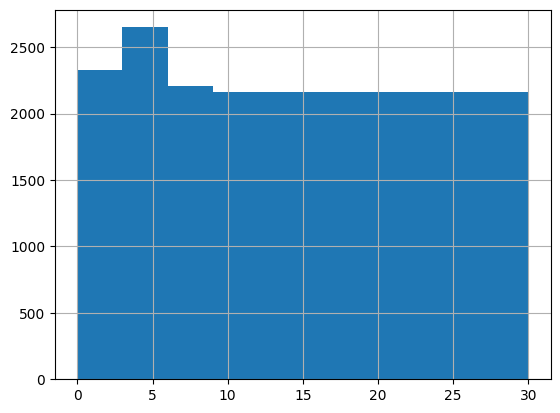

In [18]:
model_output['hours_to_hazard'].hist()

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-1hour_avg
pressure-12hour_avg
pressure-5min_var
pressure-3hour_var
pressure-6hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-6hour_avg
thrust-6hour_avg


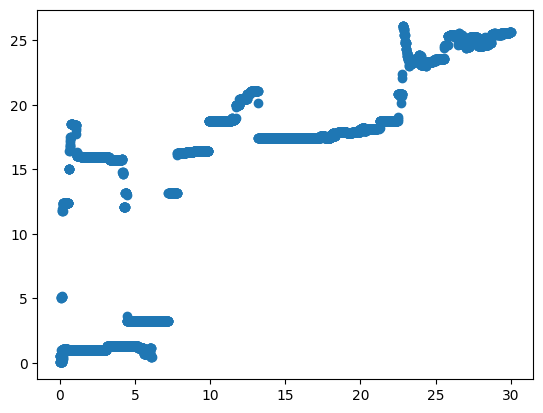

average prediction:  14.903826699738497, std: 8.21171992442289
min prediction:  0.01649999999999997, max prediction: 26.07533333333332
{'MSE': 35.65645946741685, 'MAE': 4.354617847254269, 'R2': 0.5701090051729832}
--------------------------------------


In [19]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

#y = model_output[targ].values

#X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test.values

#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
output_models['_scaling'] = scaler

#Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')

predictions = model.predict(X_test)

plt.scatter(Y_test, predictions)
#plt.title(f'{name}')
plt.show()

print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')

mse = mean_squared_error(Y_test, predictions)
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

results = {'MSE': mse, 'MAE': mae, 'R2': r2}

print(results)
print('--------------------------------------')

#duration = time.time() - start_time
#print(f"Run time: {duration / 60:.2f} minutes")
#print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
#print('--------------------------------------')

#with open(f'models/regression_models_no_screw_speed_with_normalization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
#pickle.dump((output_models, results, input_features, target_features), f)

In [20]:
test_data = pd.merge(model_input_test, model_output_test, left_index=True, right_index=True)

In [21]:
test_data.head()

,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),pressure-5min_avg,pressure-1hour_avg,pressure-12hour_avg,pressure-5min_var,pressure-3hour_var,pressure-6hour_var,die_temp-15min_avg,thrust-15min_avg,die_temp-1hour_avg,thrust-1hour_avg,die_temp-6hour_avg,thrust-6hour_avg,hours_to_hazard
Date and Time,,,,,,,,,,,,,,,,,,,,
2023-12-16 21:04:00,25.0,27.761864,274.572266,68.203995,5.53,0.88,80.0,4221.580859,4176.153630,4080.846088,1299.558743,4213.084993,3410.553877,274.572266,68.079683,274.450000,67.854533,265.406752,67.353153,30.000000
2023-12-16 21:04:30,25.0,27.761864,274.572266,67.971939,5.53,0.88,80.0,4220.403320,4177.391211,4080.939612,1297.066950,4239.141502,3426.933214,274.572266,68.075865,274.465283,67.859027,265.420763,67.354311,29.991667
2023-12-16 21:05:00,25.0,27.761864,274.572266,68.006943,5.74,0.88,80.0,4220.175977,4177.924902,4081.017295,1317.703822,4247.787738,3432.113417,274.572266,68.076787,274.480566,67.864017,265.434774,67.355753,29.983333
2023-12-16 21:05:30,25.0,27.761864,274.572266,67.880936,5.74,0.88,80.0,4211.350977,4178.617122,4081.114681,1153.035604,4256.712099,3438.463168,274.572266,68.075629,274.495850,67.866533,265.448785,67.356968,29.975000
2023-12-16 21:06:00,25.0,27.761864,274.572266,67.886215,5.41,0.88,80.0,4206.213477,4178.514876,4081.125217,1988.001994,4256.864790,3438.493943,274.572266,68.074646,274.511133,67.867397,265.462796,67.358156,29.966667


In [22]:
test_data['predicted_hours_to_hazard'] = predictions

In [34]:
well_sampled_data[well_sampled_data['HAZARD_CONDITION']].head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),sample_gap_minutes,48H_max_gap_backward,1H_max_gap_forward,well_sampled,HAZARD_CONDITION,hours_to_hazard,hazard_within_24h,pressure-5min_avg,pressure-5min_var,pressure-15min_avg,pressure-15min_var,pressure-30min_avg,pressure-30min_var,pressure-1hour_avg,pressure-1hour_var,pressure-3hour_avg,pressure-3hour_var,pressure-6hour_avg,pressure-6hour_var,pressure-12hour_avg,pressure-12hour_var,pressure-24hour_avg,pressure-24hour_var,pressure-48hour_avg,pressure-48hour_var,die_temp-15min_avg,thrust-15min_avg,screw_speed_output-15min_avg,die_temp-1hour_avg,thrust-1hour_avg,screw_speed_output-1hour_avg,die_temp-3hour_avg,thrust-3hour_avg,screw_speed_output-3hour_avg,die_temp-6hour_avg,thrust-6hour_avg,screw_speed_output-6hour_avg
Date and Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-09-19 22:40:30,5536.072266,25.0,27.782814,291.544922,54.717087,5.13,0.95,90.0,0.033333,0.150000,0.100000,True,True,0.0,True,5424.091406,2.115590e+03,5378.134245,5.745435e+03,5255.311654,2.382098e+04,5013.610286,8.169886e+04,4521.931190,222095.421451,4292.790294,174214.905152,4043.721672,161432.835024,3904.702743,103725.977238,3915.112054,110986.141270,290.559896,54.816366,25.0,285.953662,56.103403,25.0,283.510927,59.365834,25.0,283.022434,60.278684,25.0
2023-09-19 23:05:30,5542.773438,25.0,27.784546,300.277344,54.063263,4.93,0.98,90.0,0.033333,0.150000,0.066667,True,True,0.0,True,5401.469727,4.725073e+03,5308.459766,8.594834e+03,5312.035677,8.990165e+03,5247.485677,2.146594e+04,4722.677018,200422.812603,4388.878738,223925.342814,4096.327748,210191.999732,3932.718458,135401.095141,3924.884029,126753.317918,297.314583,54.133181,25.0,290.942611,54.764456,25.0,285.782954,58.323225,25.0,283.777979,59.813156,25.0
2023-09-19 23:06:00,5516.734375,25.0,27.784546,300.277344,53.860458,4.93,0.98,90.0,0.050000,0.150000,0.066667,True,True,0.0,True,5421.262305,5.006808e+03,5316.674544,9.970592e+03,5313.091764,9.360665e+03,5252.921615,2.081226e+04,4727.456255,199765.323102,4391.174278,225306.023193,4097.626746,211451.548101,3933.391074,136228.851979,3925.098898,127171.491423,297.511784,54.120357,25.0,291.087191,54.742445,25.0,285.824148,58.301677,25.0,283.802973,59.803463,25.0
2023-09-19 23:06:30,5537.648438,25.0,27.784546,300.277344,53.891983,4.93,0.98,90.0,0.050000,0.150000,0.066667,True,True,0.0,True,5443.423437,4.735945e+03,5321.483203,1.142751e+04,5315.011296,1.000879e+04,5257.287581,2.099352e+04,4732.269439,199199.767745,4393.436043,226805.882875,4098.876914,212800.855302,3934.056489,137088.503128,3925.327137,127607.552467,297.708984,54.107340,25.0,291.231771,54.720751,25.0,285.865343,58.279583,25.0,283.827968,59.793852,25.0
2023-10-25 21:17:00,6678.142578,25.0,11.709900,253.867188,18.125656,5.90,0.89,90.0,12.633333,12.633333,12.633333,True,True,0.0,True,1328.175195,3.533599e+06,931.881315,1.177866e+06,1503.327702,1.769573e+06,2521.733382,1.924715e+06,3236.132921,895189.989520,3653.770774,651724.305858,3781.741794,345790.642573,3811.535757,175549.154830,3839.538775,95216.520732,253.867188,19.935721,25.0,255.448324,56.829661,25.0,257.068636,72.018818,25.0,262.819132,79.734190,25.0


In [29]:
test_data.to_csv('test_results_ex2.csv')

<Axes: xlabel='Date and Time'>

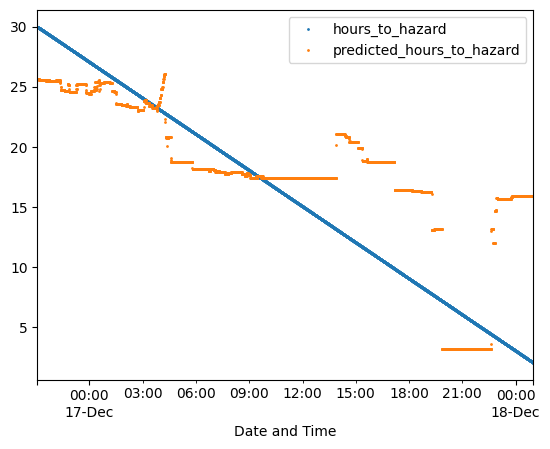

In [23]:
test_data[(test_data.index <= pd.to_datetime('12/18/2023 01:00:00')) & (test_data.index >= pd.to_datetime('12/1/2023'))][['hours_to_hazard', 'predicted_hours_to_hazard']].plot(marker='.', markersize=2, linestyle='')

In [28]:
test_data.iloc[3000:3200]

,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),pressure-5min_avg,pressure-1hour_avg,pressure-12hour_avg,...,pressure-3hour_var,pressure-6hour_var,die_temp-15min_avg,thrust-15min_avg,die_temp-1hour_avg,thrust-1hour_avg,die_temp-6hour_avg,thrust-6hour_avg,hours_to_hazard,predicted_hours_to_hazard
Date and Time,,,,,,,,,,,,,,,,,,,,,
2023-12-17 22:04:00,25.0,27.807823,262.316406,65.748001,5.29,0.88,80.0,3729.431641,3763.620964,3936.614316,...,9621.437674,24089.935908,262.316406,65.990413,262.115674,65.998501,264.917331,66.168510,5.000000,3.206167
2023-12-17 22:04:30,25.0,27.807823,262.316406,65.848862,5.29,0.88,80.0,3722.704102,3763.051204,3936.298368,...,9575.368871,24061.200208,262.316406,65.979633,262.116634,65.997356,264.921851,66.167268,4.991667,3.205500
2023-12-17 22:05:00,25.0,27.807823,262.316406,65.853760,5.29,0.88,80.0,3719.434766,3762.887988,3936.037345,...,9571.193558,24025.123953,262.316406,65.969051,262.117594,65.995695,264.926370,66.166121,4.983333,3.205500
2023-12-17 22:05:30,25.0,27.807823,262.316406,65.949509,5.29,0.88,80.0,3711.301172,3762.014014,3935.734755,...,9555.993371,24011.533128,262.316406,65.974944,262.118555,65.992279,264.930889,66.165276,4.975000,3.205500
2023-12-17 22:06:00,25.0,27.807823,262.316406,65.935806,5.34,0.88,80.0,3711.206445,3761.820540,3935.464696,...,9532.062350,23996.539554,262.316406,65.972005,262.119515,65.992778,264.935409,66.164351,4.966667,3.205500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17 23:41:30,25.0,27.762321,257.191406,65.662933,5.16,0.88,80.0,3728.567187,3765.543164,3885.574025,...,2355.505216,11581.876634,257.191406,65.654411,258.587174,65.948744,264.319309,66.003928,3.375000,15.710000
2023-12-17 23:42:00,25.0,27.762321,257.191406,65.397278,5.16,0.88,80.0,3734.767188,3765.621647,3885.354076,...,2355.246033,11514.831315,257.191406,65.639459,258.555452,65.941001,264.301318,66.002018,3.366667,15.717750
2023-12-17 23:42:30,25.0,27.762321,254.681641,65.397278,5.16,0.88,80.0,3735.529883,3765.703499,3885.073492,...,2346.772800,11409.313921,257.107747,65.624507,258.502816,65.934544,264.279842,66.000279,3.358333,15.718083


In [29]:
model_input_test.head()

,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),pressure-5min_avg,pressure-1hour_avg,pressure-12hour_avg,pressure-5min_var,pressure-3hour_var,pressure-6hour_var,die_temp-15min_avg,thrust-15min_avg,die_temp-1hour_avg,thrust-1hour_avg,die_temp-6hour_avg,thrust-6hour_avg
Date and Time,,,,,,,,,,,,,,,,,,,
2023-12-03 16:57:00,25.0,31.605782,257.505859,75.099335,5.49,0.88,80.0,4457.618164,4508.503743,4907.481562,518.357419,44953.588010,40503.950719,261.466797,75.200685,264.063688,74.386289,273.704072,68.699664
2023-12-03 16:57:30,25.0,31.605782,257.505859,75.138000,5.49,0.88,80.0,4465.017383,4507.811100,4907.198600,910.551339,44905.015707,40638.786924,261.246745,75.199172,263.952637,74.436745,273.675871,68.708716
2023-12-03 16:58:00,25.0,31.605782,257.505859,75.199539,5.49,0.88,80.0,4458.041992,4506.084945,4906.800640,872.925404,45009.918653,40858.832322,261.026693,75.205372,263.841585,74.481827,273.647670,68.717830
2023-12-03 16:58:30,25.0,31.605782,257.505859,75.237625,5.49,0.88,80.0,4462.179688,4505.197103,4906.462169,959.446157,44946.728797,41023.605882,260.806641,75.203710,263.730534,74.527422,273.619469,68.727274
2023-12-03 16:59:00,25.0,31.605782,257.505859,75.114212,5.18,0.88,80.0,4461.632031,4504.089616,4906.143591,971.953352,45002.556078,41227.976303,260.586589,75.209813,263.619482,74.571892,273.591268,68.736437


In [46]:
#with open(f'models/regression_models_no_screw_speed_with_normalization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
#    pickle.dump((output_models, results, input_features, target_features), f)

In [14]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-1hour_avg',
    'pressure-12hour_avg',
    'pressure-5min_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_features]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-1hour_avg
pressure-12hour_avg
pressure-5min_var
pressure-3hour_var
pressure-6hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-6hour_avg
thrust-6hour_avg
here first
here

Current Time: 15:15:14
results for target: hours_to_hazard, model: Linear Regression


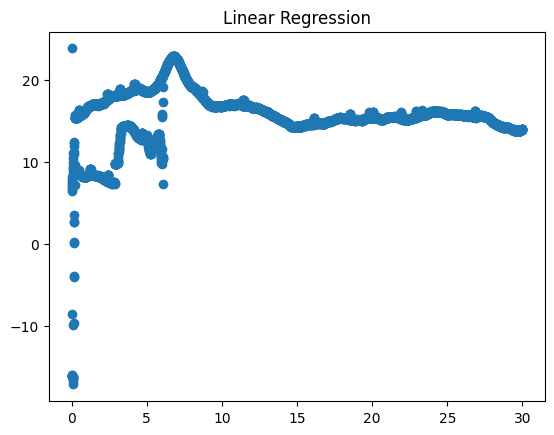

average prediction:  15.308983812112793, std: 3.576961794242
min prediction:  -17.13982837232676, max prediction: 23.826999796430513
{'MSE': 94.71386575600795, 'MAE': 8.535712546086359, 'R2': -0.14191477734826563}
--------------------------------------
Run time: 0.00 minutes
Current Time: 15:15:14
--------------------------------------

Current Time: 15:15:14
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


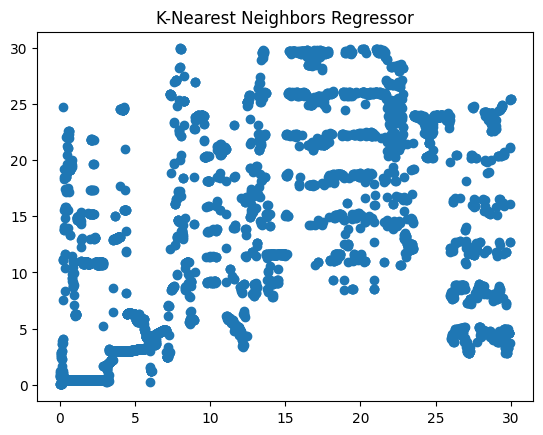

average prediction:  13.344782725734502, std: 9.272879446749739
min prediction:  0.02499999999999996, max prediction: 29.93333333333333
{'MSE': 84.66629021496692, 'MAE': 6.63008883248731, 'R2': -0.020776495268274076}
--------------------------------------
Run time: 0.02 minutes
Current Time: 15:15:15
--------------------------------------

Current Time: 15:15:15
results for target: hours_to_hazard, model: Random Forest Regressor


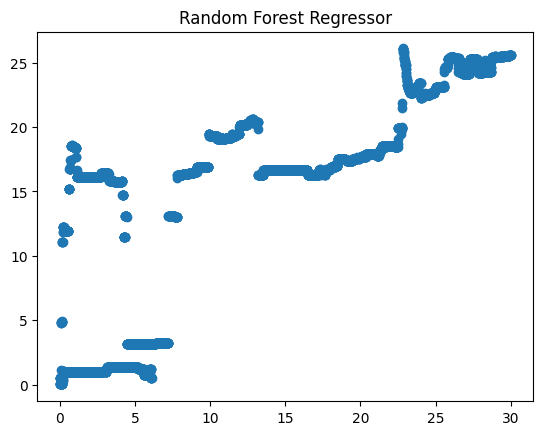

average prediction:  14.697859675434547, std: 8.090101753594512
min prediction:  0.02241666666666663, max prediction: 26.093499999999985
{'MSE': 36.23327732166526, 'MAE': 4.422894939240117, 'R2': 0.5631546186494578}
--------------------------------------
Run time: 0.25 minutes
Current Time: 15:15:29
--------------------------------------

Current Time: 15:15:29
results for target: hours_to_hazard, model: Support Vector Regressor


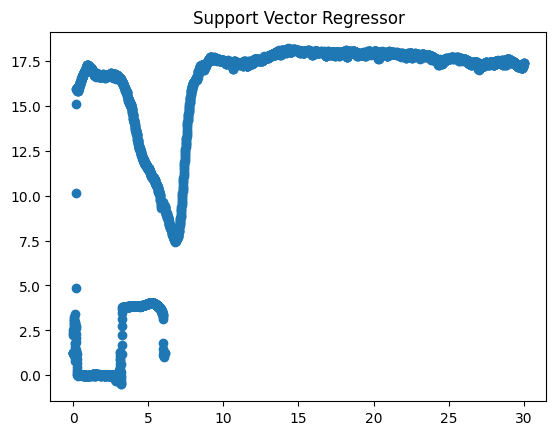

average prediction:  14.031132267591216, std: 6.075778950922166
min prediction:  -0.5084012895466072, max prediction: 18.182474672570102
{'MSE': 51.779338178841094, 'MAE': 5.709909710791277, 'R2': 0.3757240193315491}
--------------------------------------
Run time: 0.46 minutes
Current Time: 15:15:41
--------------------------------------

Current Time: 15:15:41
results for target: hours_to_hazard, model: Gradient Boosting Regressor


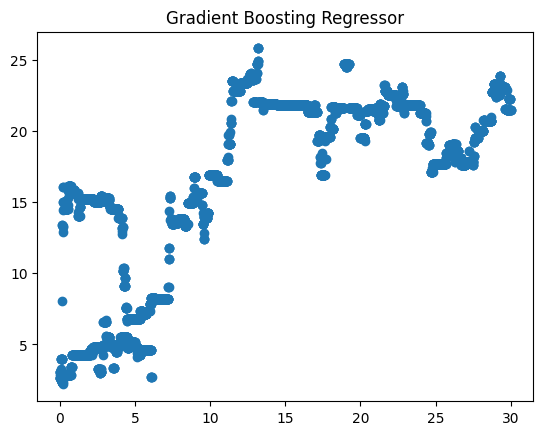

average prediction:  15.72228169393768, std: 6.684264986221185
min prediction:  2.193114748589237, max prediction: 25.77411677293931
{'MSE': 45.06374193307721, 'MAE': 5.3912271608286275, 'R2': 0.4566903966463285}
--------------------------------------
Run time: 0.55 minutes
Current Time: 15:15:47
--------------------------------------

Current Time: 15:15:47
results for target: hours_to_hazard, model: MLP Regressor


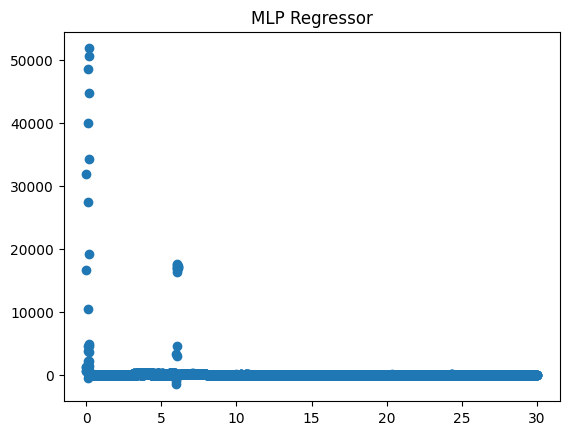

average prediction:  167.47449032435472, std: 2014.5542091053385
min prediction:  -1534.0206127158513, max prediction: 51810.51552352544
{'MSE': 4085659.596943147, 'MAE': 171.78384193941235, 'R2': -49257.627886468625}
--------------------------------------
Run time: 0.56 minutes
Current Time: 15:15:48
--------------------------------------


In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

with open(f'models/regression_models_no_screw_speed_no_normalization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results, input_features, target_features), f)

In [51]:
target_feature = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)']

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_feature]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
here first
here

Current Time: 14:52:23
results for target: hours_to_hazard, model: Linear Regression


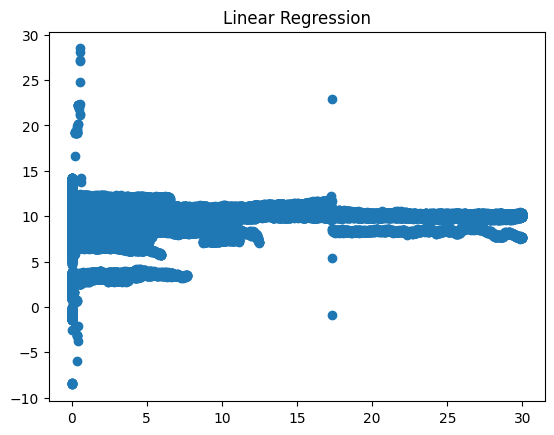

average prediction:  8.376707108738579, std: 2.8549650753757745
min prediction:  -8.550264825757234, max prediction: 28.475501978459533
{'MSE': 72.36673332516173, 'MAE': 7.625421313300662, 'R2': -0.6547291801246231}
--------------------------------------
Run time: 0.01 minutes
Current Time: 14:52:23
--------------------------------------

Current Time: 14:52:23
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


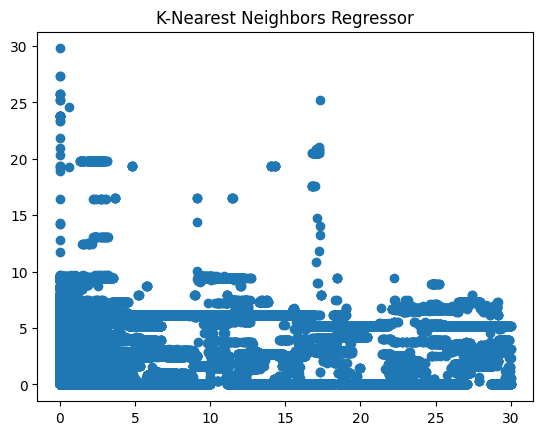

average prediction:  2.2738103747805787, std: 2.4915712252829927
min prediction:  0.0, max prediction: 29.78333333333333
{'MSE': 47.29956776744261, 'MAE': 3.954128075667916, 'R2': -0.08154633207487594}
--------------------------------------
Run time: 0.02 minutes
Current Time: 14:52:24
--------------------------------------

Current Time: 14:52:24
results for target: hours_to_hazard, model: Random Forest Regressor


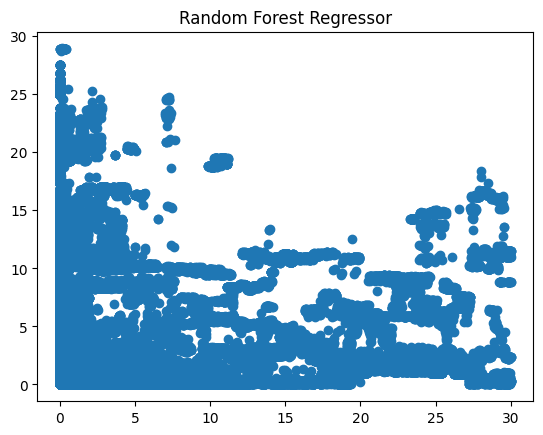

average prediction:  4.7384925071692185, std: 5.931371306078472
min prediction:  0.0, max prediction: 28.936833333333315
{'MSE': 82.98308769774368, 'MAE': 5.990022071515246, 'R2': -0.8974814857720432}
--------------------------------------
Run time: 0.58 minutes
Current Time: 14:52:58
--------------------------------------

Current Time: 14:52:58
results for target: hours_to_hazard, model: Support Vector Regressor


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

In [ ]:
with open(f'models/regression_models_base_only_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)

In [47]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-3hour_avg',
    'pressure-6hour_avg',
    'pressure-12hour_avg',
    'pressure-24hour_avg',
    'pressure-48hour_avg',
    'pressure-5min_var',
    'pressure-15min_var',
    'pressure-30min_var',
    'pressure-1hour_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'pressure-12hour_var',
    'pressure-24hour_var',
    'pressure-48hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'screw_speed_output-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'screw_speed_output-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
    'screw_speed_output-3hour_avg',
]

In [48]:
#model_input = ex_data[ex_data['hours_to_next_pause'] <= 6][input_features]
#model_output = ex_data[ex_data['hours_to_next_pause'] <= 6][target_features]

In [49]:
train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

In [50]:
print('input variables:')
for var in model_input.columns:
    print(var)

# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_next_pause'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_true = np.sum((Y_train == 1))
n_false = np.sum((Y_train == 0))

print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')

    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)

    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-3hour_avg
pressure-6hour_avg
pressure-12hour_avg
pressure-24hour_avg
pressure-48hour_avg
pressure-5min_var
pressure-15min_var
pressure-30min_var
pressure-1hour_var
pressure-3hour_var
pressure-6hour_var
pressure-12hour_var
pressure-24hour_var
pressure-48hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
die_temp-6hour_avg
thrust-6hour_avg


KeyError: 'hours_to_next_pause'

In [ ]:
with open(f'models/regression_models_with_screw_speed_no_5T_{extruder}_12H.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)

In [ ]:
def clean_extruder_data_old(extruder_data):
    
    extruder_data = extruder_data.drop(extruder_data.index[0])
    extruder_data = extruder_data.replace("<null>", None)
    
    extruder_data = extruder_data.dropna()

    # Convert the column to string type
    for column in extruder_data.columns:
        if column not in ["Date and Time", "AnomalyScore"]:
            extruder_data[column] = extruder_data[column].astype(str)
            #extruder_data[column] = extruder_data[column].str.replace("<null>", None)
            # Replace commas with an empty string
            extruder_data[column] = extruder_data[column].str.replace(",", "")

            # Convert the column back to numeric type, handling any conversion errors
            extruder_data[column] = pd.to_numeric(extruder_data[column], errors="coerce")
            
    extruder_data = extruder_data[(extruder_data['Extruder Pressure'] >= 0) & \
                              (extruder_data['Extruder Pressure'] < 50000)]

    extruder_data['Date and Time'] = pd.to_datetime(extruder_data['Date and Time'])
    
    return extruder_data